# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание проекта.

### Цель - разработать модель для определения рыночной стоимости автомобиля, отвечающую критериям заказчика.

### Задачи: 
1. Загрузить данные.
2. Изучить, заполнить пропущенные значения, обработать аномалии в столбцах. оставить только информативные признаки.
3. Подготовить выборки для обучения моделей.
4. Обучить модели: LightGBM, LinearRegression, - с разными гиперпараметрами.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Выбрать лучшую модель, проверить её качество на тестовой выборке.

### Описание данных:
Признаки: 
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя.

Целевой признак:
- Price — цена (евро)

## Загрузка данных

In [1]:
#pip install --upgrade scikit-learn -q
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.4 MB)


In [2]:
pip install category_encoders -q


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Загрeзка библиотек
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import KFold
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [5]:
start_1 = time.time()

In [6]:
RANDOM_STATE = 1234

In [7]:
data = pd.read_csv('/datasets/autos.csv')

In [8]:
data.sample(8) #для более продуктивного знакомства с файлом, выведем 8 случайных строк.

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
213879,2016-04-04 10:56:55,550,sedan,1996,manual,71,astra,150000,5,petrol,opel,no,2016-04-04 00:00:00,0,47139,2016-04-04 11:46:54
96616,2016-03-11 22:50:10,2200,small,2004,manual,65,yaris,90000,3,petrol,toyota,no,2016-03-11 00:00:00,0,21035,2016-03-30 09:16:26
228605,2016-04-03 15:38:51,2600,wagon,2003,manual,116,3er,150000,1,gasoline,bmw,yes,2016-04-03 00:00:00,0,51399,2016-04-03 15:38:51
186451,2016-03-12 22:36:18,9250,wagon,2006,manual,116,a3,90000,11,petrol,audi,no,2016-03-12 00:00:00,0,21684,2016-03-19 11:44:54
97670,2016-03-05 15:47:49,400,sedan,1998,manual,75,lancer,150000,6,petrol,mitsubishi,no,2016-03-05 00:00:00,0,15859,2016-03-31 01:15:20
222716,2016-03-11 21:51:30,2250,wagon,2002,auto,150,3er,150000,1,gasoline,bmw,no,2016-03-11 00:00:00,0,85283,2016-03-16 14:15:31
177012,2016-03-12 10:38:23,15990,wagon,2009,manual,163,v70,80000,4,gasoline,volvo,no,2016-03-12 00:00:00,0,25899,2016-03-20 14:49:51
140809,2016-03-22 00:52:27,1500,wagon,2004,manual,0,rio,100000,12,petrol,kia,NaN,2016-03-21 00:00:00,0,16225,2016-03-22 06:49:04


Названия столбцов не соответствуют правилам. Многие важные столбцы содержат пропуски: VehicleType, Gearbox, Model, FuelType, Repaired.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Вывод:** В таблице более 354 тыс. строк и 16 столбцов. Хорошо, что нет пропусков в целевой переменной. Столбцы VehicleType, Gearbox, Model, FuelType, Repaired содержат пропуски, некоторые из них примерно 10%. А это важные столбцы. Типы данных: целочисленные и текстовые.

### Предобработка

Исправление названий столбцов из "верблюжьего" формата в "змеинный".


In [10]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)  
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)  
    return name.lower()

data.columns = [camel_to_snake(col) for col in data.columns]

print(data.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


In [11]:
def prep(df): #создадим функцию для предобработки данных
    print(df.info())
    print("Количество строк таблицы до удаления дубликатов: ", df.shape[0])
    df = df.drop_duplicates().reset_index(drop=True)
    print("Размер таблицы после удаления дубликатов: ", df.shape)
    print ("Количество дубликатов после их удаления: ", df.duplicated().sum())
    print('Уникальные значения в столбцах:')
    i=0
    for i in df.columns:
        try:
            print(f"  В столбце  {i}  такие уникальные значения:")
            print(df[i].sort_values().unique())
        except:
            print ('Похоже, ошибка в типе данных в столбце', i)
        print()    
    j=0
    for j in df.columns:
        print (f"Доля пропусков в столбце {j} - {round(df[j].isna().sum()*100/df.shape[0],2)} %")
      
    return df.sample(5)

In [12]:
prep(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
130125,2016-03-25 14:42:34,9000,wagon,2008,manual,105,transporter,150000,5,gasoline,volkswagen,no,2016-03-25 00:00:00,0,97486,2016-03-25 14:42:34
249970,2016-03-16 18:54:29,16700,sedan,2008,auto,435,a6,150000,4,petrol,audi,NaN,2016-03-16 00:00:00,0,65933,2016-03-17 16:38:42
226647,2016-03-10 12:47:28,899,small,2003,manual,73,c3,150000,5,petrol,citroen,no,2016-03-10 00:00:00,0,70376,2016-03-12 01:46:37
23169,2016-03-19 13:49:11,1450,small,2003,manual,75,corsa,150000,1,petrol,opel,yes,2016-03-19 00:00:00,0,13407,2016-03-21 18:18:48
344629,2016-03-16 15:54:27,2500,NaN,2018,manual,116,a3,150000,6,petrol,audi,no,2016-03-16 00:00:00,0,65933,2016-04-03 21:16:28


Столбец "Год регистрации автомобиля" содержит аномальные значения: 1000, 1001, 1039..., 9996, 9999. Трудно сказать, что имели ввиду респонденты, заполняя данные таким образом, но их нельзя использовать для обучения модели. Предлагаю строки с этими данными удалить. 

Мощность автомобиля также содержит аномальные значения, слишком большие и слишком маленькие. После исследовательского анализа удалим аномалии.

Моделей машин слишком много. Предлагается взять k самых крупных по количеству, остальные заменить на "другая". Также удалим строки с незаполненными моделями машин.

Столбцы date_crawled, registration_month, date_created, postal_code, last_seen неинформативны, их можно не брать в выборку.

Столбцы vehicle_type, fuel_type, gearbox содержат большое количество пропусков. Их можно заполнить самым популярным значением по группе моделей. 

Пропуски в столбце model ничем не заполнить. Предлагается их удалить.

Пропуски  в столбце repaired предлагается заполнить "yes", т.к. автомобиль без ремонта - редкость.

#### Год_регистрации (registration_year)

In [13]:
# Удаление строк с аномальными значениями Года регистрации
data_1 = data.query('1910 <= registration_year <= 2025')
data_1.shape[0]

354198

Таблица почти ничего не потеряла после удаления аномалий в столбце "Год регистрации автомобиля": было 354 365, стало 354 198 строк. Зато теперь указаны автомобили с 1910 по 2025 годы выпуска.

#### Модель автомобиля (model)

In [14]:
d = data_1.pivot_table(index = 'model', values=['date_crawled'],aggfunc = 'count')
e = d.sort_values(by = 'date_crawled', ascending = False)
e

,date_crawled
model,
golf,29218
other,24403
3er,19756
polo,13063
corsa,12564
...,...
serie_2,8
serie_3,4
rangerover,4


250 различных моделей автомобилей. Возьмем самые крупные 100 моделей, остальные заменим на other. Но обратим внимание, что в таблице уже есть 24 тыс. моделей "другие".

In [15]:
k=240 #Оставляем k названий моделей, остальные заменим на other
f = e.index[:k]   

g = data_1.query('model in @f')
print()
print(f'Размер выборки с {k} самыми многочисленными моделями  из {data_1.shape[0]} - ', g.shape[0])
sr = data_1.loc[:,'model'].apply(lambda x: x if x in f else 'other')
data_1.loc[:,'model_other'] = sr #заменяем малочисленные категории на outher
print('После замены в тренировочных данных категорий столо', data_1['model_other'].nunique())
k_1 = data_1.query('model_other == "other"').shape[0]*100 /data_1.shape[0]
print(f'Среди названий моделей {round(k_1,0)} процентов относится к модели other')



Размер выборки с 240 самыми многочисленными моделями  из 354198 -  334494
После замены в тренировочных данных категорий столо 240
Среди названий моделей 12.0 процентов относится к модели other


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Итак, в важном столбце Модель малочисленные модели и пропуски заменили значением other. 

#### Удаление неважных столбцов

In [16]:
data_1 = data_1.drop(
    ['model', 'date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen', 'number_of_pictures']
                     , axis=1)

In [17]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354198 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354198 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354198 non-null  int64 
 3   gearbox            334503 non-null  object
 4   power              354198 non-null  int64 
 5   kilometer          354198 non-null  int64 
 6   fuel_type          321431 non-null  object
 7   brand              354198 non-null  object
 8   repaired           283191 non-null  object
 9   model_other        354198 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Итак, осталось 10 столбцов.

#### Тип кузова, тип топлива, тип коробки передач (vehicle_type, fuel_type, gearbox)

In [18]:
categorical_columns = ['vehicle_type', 'fuel_type', 'gearbox'] 
group_column = 'model_other'
#заполним пропуски в указанных столбцах самыми популярными значениями по группам моделей автомобилей.
for col in categorical_columns: 
    data_1[col] = data_1.groupby(group_column)[col].transform(
        lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
    )
    
data_1.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354198 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354198 non-null  int64 
 1   vehicle_type       354198 non-null  object
 2   registration_year  354198 non-null  int64 
 3   gearbox            354198 non-null  object
 4   power              354198 non-null  int64 
 5   kilometer          354198 non-null  int64 
 6   fuel_type          354198 non-null  object
 7   brand              354198 non-null  object
 8   repaired           283191 non-null  object
 9   model_other        354198 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Итак,  vehicle_type, fuel_type, gearbox заполнены самыми популярными значениями в зависимости от группы моделей автомобиля. Теперь 9 из 10 столбцов не содержат пропусков.

#### Контроль

In [19]:
def prep_1(df): #создадим функцию для предобработки данных
    print(df.info())
    #print("Количество строк таблицы до удаления дубликатов: ", df.shape[0])
    #df = df.drop_duplicates().reset_index(drop=True)
    #print("Размер таблицы после удаления дубликатов: ", df.shape)
    print ("Количество дубликатов:", df.duplicated().sum())
    print('Уникальные значения в столбцах:')
    i=0
    for i in df.columns:
        try:
            print(f"  В столбце  {i}  такие уникальные значения:")
            print(df[i].sort_values().unique())
        except:
            print ('Похоже, ошибка в типе данных в столбце', i)
        print()    
    j=0
    for j in df.columns:
        print (f"Доля пропусков в столбце {j} - {round(df[j].isna().sum()*100/df.shape[0],2)} %")
      
    return df.sample(5)

In [20]:
prep_1(data_1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354198 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354198 non-null  int64 
 1   vehicle_type       354198 non-null  object
 2   registration_year  354198 non-null  int64 
 3   gearbox            354198 non-null  object
 4   power              354198 non-null  int64 
 5   kilometer          354198 non-null  int64 
 6   fuel_type          354198 non-null  object
 7   brand              354198 non-null  object
 8   repaired           283191 non-null  object
 9   model_other        354198 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB
None
Количество дубликатов: 49200
Уникальные значения в столбцах:
  В столбце  price  такие уникальные значения:
[    0     1     2 ... 19998 19999 20000]

  В столбце  vehicle_type  такие уникальные значения:
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small'

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired,model_other
341276,2800,sedan,2000,manual,118,150000,petrol,bmw,no,3er
250685,270,sedan,2016,manual,58,150000,petrol,opel,yes,other
79840,1100,bus,2001,manual,129,150000,gasoline,kia,no,carnival
280461,6100,small,2010,manual,82,70000,petrol,ford,NaN,fiesta
278804,1200,sedan,1999,manual,58,100000,petrol,renault,no,clio


*ВЫВОД:* Итак, удалили дубликаты, неинформативные столбцы, заполнили пропуски. 

Удалены строки с некорректным годом выпуска автомобилей: меньше 1910 и больше 2025.

в важном столбце Модель малочисленные модели и пропуски заменили значением other.

В новой таблице также есть много дубликатов, но их удалаять не требуется, т.к. совпадение автмобилей по 10 признакам возможно. Остался один столбец, с пропусками repaired. О заполнении пропусков решим после исследовательского анализа.

### Исследовательский анализ (частичный)

In [21]:
def categ (column, quantity, name): #функция для анализа категориальных столбцов
    plt.figure(figsize=(22, 18))
    v1 = data_1[column].value_counts().head(quantity)


    lb1 = v1.index
    #lb2 = v2.index

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.pie(v1, labels=lb1, autopct='%1.1f%%')
    ax.set_title(name)

    return

In [22]:
def numbers(df, column, x_title,y_title): #функция для анализа числовых столбцов
    plt.figure(figsize=(16, 12))

    plt.subplot(2,2,1)
    df[column].hist(bins=15)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.title('Распределение тренировочных данных')

    
    try:
        plt.subplot(2,2,3)
        df.boxplot(column, color = 'green')
        plt.ylabel(x_title)
        plt.title('Ящик с усами тренировоных данных')

    except:
        print('Ящик с усами не построить')
    plt.show()
    
    print('Статистика тренировочных данных')
    print(df[column].describe())#datetime_is_numeric=True))

    return;

#### Мощность (power)

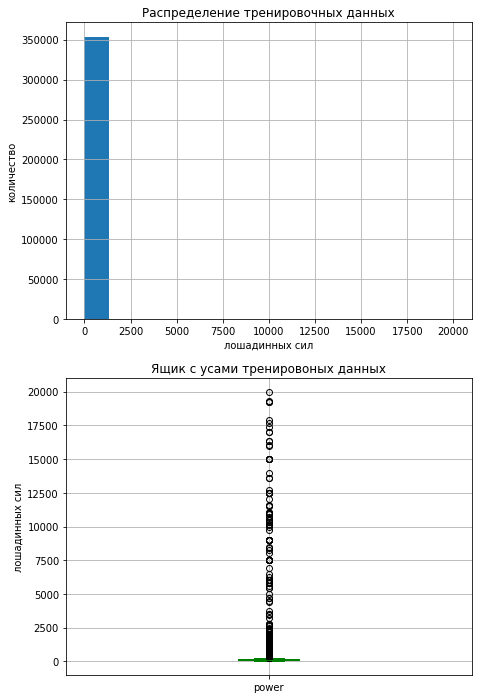

Статистика тренировочных данных
count    354198.000000
mean        110.078242
std         189.536766
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


In [23]:
numbers(data_1, 'power', "лошадинных сил", 'количество')

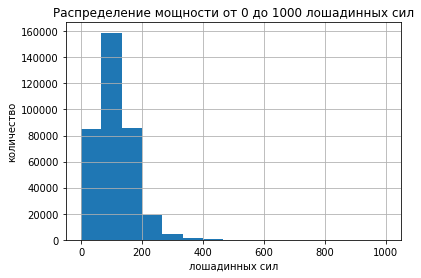

In [24]:
data_1['power'].hist(bins=15, range=(0,1000));
plt.ylabel('количество')
plt.xlabel("лошадинных сил")
plt.title('Распределение мощности от 0 до 1000 лошадинных сил');

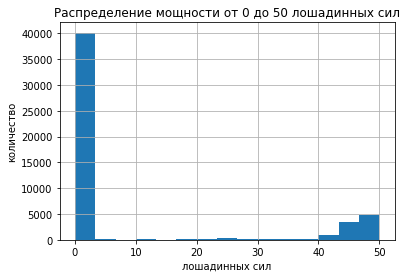

In [25]:
data_1['power'].hist(bins=15, range=(0,50))
plt.ylabel('количество')
plt.xlabel("лошадинных сил")
plt.title('Распределение мощности от 0 до 50 лошадинных сил');

Столбец Мощность содержит большое количество выбросов. Рассмотрев ближе график, видим, что 40 тысяч строк (более 10 %) содержат мощность 0, т.е. не заполнена. Заполним мощность таких автомобилей медианным значением по группе моделей.

In [26]:
for p in data_1['model_other'].unique(): #Определим среднюю мощность моделей авто
    cp = data_1.loc[(data_1['model_other'] == p), 'power'].median()
    if cp == 0:
        print(f'Мощность {p} равна 0')
 

In [27]:
for p in data_1['model_other'].unique(): #Определим медианную мощность моделей авто  в зависимости от модели
    cp = data_1.loc[(data_1['model_other'] == p), 'power'].median()
    data_1.loc[(data_1['model_other'] == p) & (data_1['power'] == 0),'power'] = cp

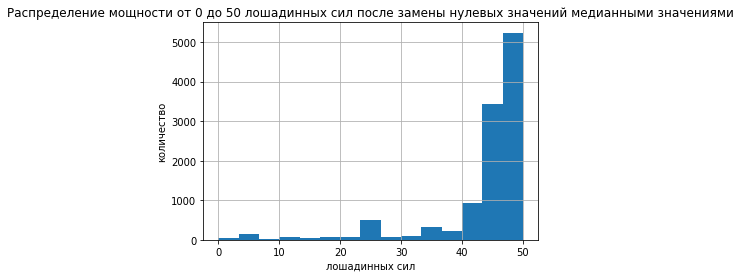

In [28]:
data_1['power'].hist(bins=15, range=(0,50))
plt.ylabel('количество')
plt.xlabel("лошадинных сил")
plt.title('Распределение мощности от 0 до 50 лошадинных сил после замены нулевых значений медианными значениями');

In [29]:
data_1['power'].describe()

count    354198.000000
mean        121.700806
std         185.926034
min           1.000000
25%          75.000000
50%         109.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Итак, больше автомобилей с нулевой мощностью нет, их мощность заменена на медианное значение в завиcимости от модели

#### Наличие ремонта (repaired)

In [30]:
data_1['repaired'].fillna('yes')
data_1['repaired'].value_counts()

no     247146
yes     36045
Name: repaired, dtype: int64

<Figure size 1584x1296 with 0 Axes>

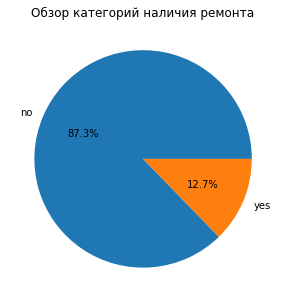

In [31]:
categ("repaired", 3, 'Обзор категорий наличия ремонта')

Налицо дисбаланс данных. Вспомним, что в этом столбце 20% пропусков, которые придется оставить.

#### Модели и тип коробки передач

<Figure size 1584x1296 with 0 Axes>

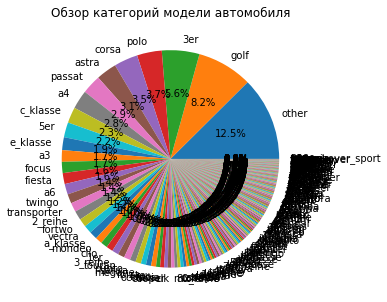

In [32]:
categ('model_other', 240, 'Обзор категорий модели автомобиля')

"Другие" - самая большая категория.

<Figure size 1584x1296 with 0 Axes>

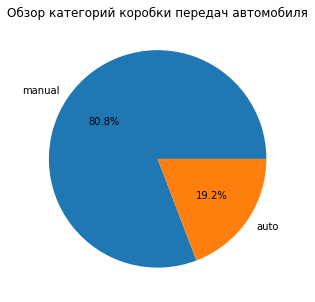

In [33]:
categ('gearbox', 20, 'Обзор категорий коробки передач автомобиля')

*ВЫВОД:* получили таблицу, где 354198 строк и 10 столбцов. Есть выбросы, дисбаланс, пропуски, большая часть автомобилей с неопределенной категорией.

In [34]:
# КОД РЕВЬЮЕРА
data_1.duplicated().sum()

50929

#### Контроль дубликатов

После предобработки и прочих манипуляций с таблицей необходимо проверить дубликаты и удалить их.

In [35]:
print("Количество строк таблицы до удаления дубликатов: ", data_1.shape[0])
data_1 = data_1.drop_duplicates().reset_index(drop=True)
print("Размер таблицы после удаления дубликатов: ", data_1.shape)

Количество строк таблицы до удаления дубликатов:  354198
Размер таблицы после удаления дубликатов:  (303269, 10)


## Обучение моделей

### Модель DecisionTreeRegressor

Подготовим обучающую валидационную и тестовую выборки. Отделим целевой признак от входных.

#### Подготовка признаков

In [36]:

features_train, features_test, target_train, target_test = train_test_split(
    data_1.drop('price', axis=1), data_1.price, test_size=0.25, random_state=1234)


In [37]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)


(227451, 9)
(75818, 9)
(227451,)
(75818,)


In [38]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227451 entries, 39253 to 165158
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   vehicle_type       227451 non-null  object 
 1   registration_year  227451 non-null  int64  
 2   gearbox            227451 non-null  object 
 3   power              227451 non-null  float64
 4   kilometer          227451 non-null  int64  
 5   fuel_type          227451 non-null  object 
 6   brand              227451 non-null  object 
 7   repaired           180828 non-null  object 
 8   model_other        227451 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 17.4+ MB


In [39]:
num_columns = ['registration_year', 'power', 'kilometer'] 
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type','repaired']
many_category_columns =['model_other', 'brand']

#### Подготовка признаков, перебор гиперпараметров, обучение в пайплайне.

In [40]:
start = time.time()
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
#ord_pipe = Pipeline(
#    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan
#            )
#        ),
#     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
#    ]
#)
data_preprocessor = ColumnTransformer( 
    [('ohe', ohe_pipe, ohe_columns),
     ('target', TargetEncoder(smoothing=1.0), many_category_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
).set_output(transform="pandas")

#Добавляю полный пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

parameters = {
    'models__max_depth': range(1, 11)
#    'models__max_features': range(2, 9)    
}

gs = GridSearchCV(
    pipe_final,
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
)

gs.fit(features_train, target_train) 

print('Лучшие параметры модели - ', gs.best_estimator_)

print('RMSE этой модели на тренировочных данных - ', -round(gs.best_score_,0))

print('Время обучения модели на оптимальном наборе данных -',gs.cv_results_['mean_fit_time'][gs.best_index_])

y_pred = gs.predict(features_train)

print('Время предсказания модели - ', gs.cv_results_['mean_score_time'][gs.best_index_])

print('Время работы пайплайна',time.time() - start)

Лучшие параметры модели -  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'repaired']),
                                                 ('target',
                             

*ВЫВОД:* Модель DecisionTreeRegressor(max_depth=10, random_state=1234) обучилась за 1 с. Предсказала за 0,1 с. Метрика RMSE на тренировочных данных 2154.

### Модель LightGBM

#### Подготовка признаков

In [47]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227451 entries, 39253 to 165158
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   vehicle_type       227451 non-null  object 
 1   registration_year  227451 non-null  int64  
 2   gearbox            227451 non-null  object 
 3   power              227451 non-null  float64
 4   kilometer          227451 non-null  int64  
 5   fuel_type          227451 non-null  object 
 6   brand              227451 non-null  object 
 7   repaired           180828 non-null  object 
 8   model_other        227451 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 17.4+ MB


In [48]:
categorical_features =['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired', 'model_other']
for col in categorical_features:
    data_1[col] = data_1[col].astype('category')
    
data_1.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303269 entries, 0 to 303268
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              303269 non-null  int64   
 1   vehicle_type       303269 non-null  category
 2   registration_year  303269 non-null  int64   
 3   gearbox            303269 non-null  category
 4   power              303269 non-null  float64 
 5   kilometer          303269 non-null  int64   
 6   fuel_type          303269 non-null  category
 7   brand              303269 non-null  category
 8   repaired           241165 non-null  category
 9   model_other        303269 non-null  category
dtypes: category(6), float64(1), int64(3)
memory usage: 11.3 MB


In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    data_1.drop('price', axis=1), data_1.price, test_size=0.25, random_state=RANDOM_STATE)

In [50]:
train_data = lgb.Dataset(X_train, label=y_train)
                      

#### Обучение

In [51]:
start = time.time()

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate":0.1,
    "num_leaves":40,
    "categorical_feature": categorical_features
}
model = lgb.train(params, train_data)
print()
print('Время обучения модели LightGBM',time.time() - start)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] categorical_feature is set=vehicle_type,gearbox,fuel_type,brand,repaired,model_other, categorical_column=0,2,5,6,7,8 will be ignored. Current value: categorical_feature=vehicle_type,gearbox,fuel_type,brand,repaired,model_other
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 227451, number of used features: 9
[LightGBM] [Info] Start training from score 4547.069184

Время обучения модели LightGBM 5.930392265319824


In [52]:
start = time.time()
y_pred = model.predict(X_train)
print('Время предсказания модели LightGBM',time.time() - start)


rmse = root_mean_squared_error(y_train, y_pred)
#result = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

print(f"RMSE этой модели на тренировочных данных: {rmse:.0f}")

Время предсказания модели LightGBM 2.6063027381896973
RMSE этой модели на тренировочных данных: 1763


Итак, время обучения модели LightGBM 6 секунды. Предсказала за 3 с. Метрика RMSE на тренировочных данных 1763.

## Анализ моделей

Несмотря на бОльшее время обучения и предсказания, модель LightGBM точнее предсказывает цену автомобиля, чем DecisionTreeRegressor. Проверим ее качество на тестовых данных.

In [53]:
start = time.time()
y_pred = model.predict(X_test)
print('Время предсказания модели LightGBM',time.time() - start)


rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE этой модели на тренировочных данных: {rmse:.0f}")

Время предсказания модели LightGBM 0.8921358585357666
RMSE этой модели на тренировочных данных: 1831


Время предсказания на тестовой выборке составило 1 с, качество предсказания также хорошее: RMSE = 1859.

**ВЫВОД:** *Найдена качественная модель предсказания рыночной стоимости автомобиля. Это LightGBM ("learning_rate":0.1, "num_leaves":40). Она обучается за 6 с, предсказывает за 3 с. RMSE  модели 1831.*

In [54]:
print('Время выполнения кода',time.time() - start_1)

Время выполнения кода 95.82582640647888


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей